<a href="https://colab.research.google.com/github/Andrea-Cristini/sailgp/blob/main/SailGP_tack_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291 entries, 0 to 6290
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6291 non-null   int64  
 1   BOAT                    6291 non-null   object 
 2   type                    6291 non-null   object 
 3   WING_CONFIG_unk         6291 non-null   float64
 4   DATETIME                6291 non-null   object 
 5   entry_bsp               6291 non-null   float64
 6   exit_bsp                6291 non-null   float64
 7   min_bsp                 6291 non-null   float64
 8   bsp_loss                6291 non-null   float64
 9   entry_twa               6291 non-null   float64
 10  exit_twa                6291 non-null   float64
 11  entry_rh                6288 non-null   float64
 12  exit_rh                 6291 non-null   float64
 13  entry_rh_stability      6276 non-null   float64
 14  max_yaw_rate            6291 no

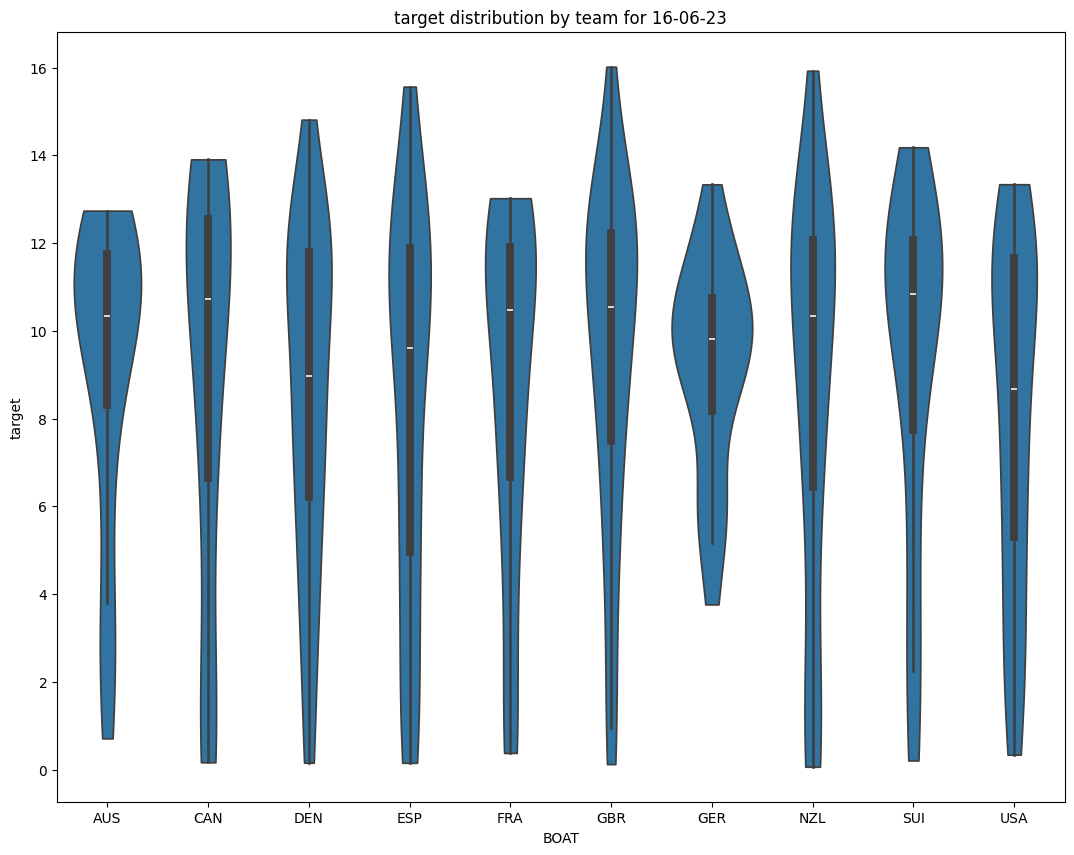



NOTE: 
    Distributions are non-normal - need to account for outliers





NOTE: 
    Mixture of correlations and no relationship to target, some features
    are discrete e.g. tws



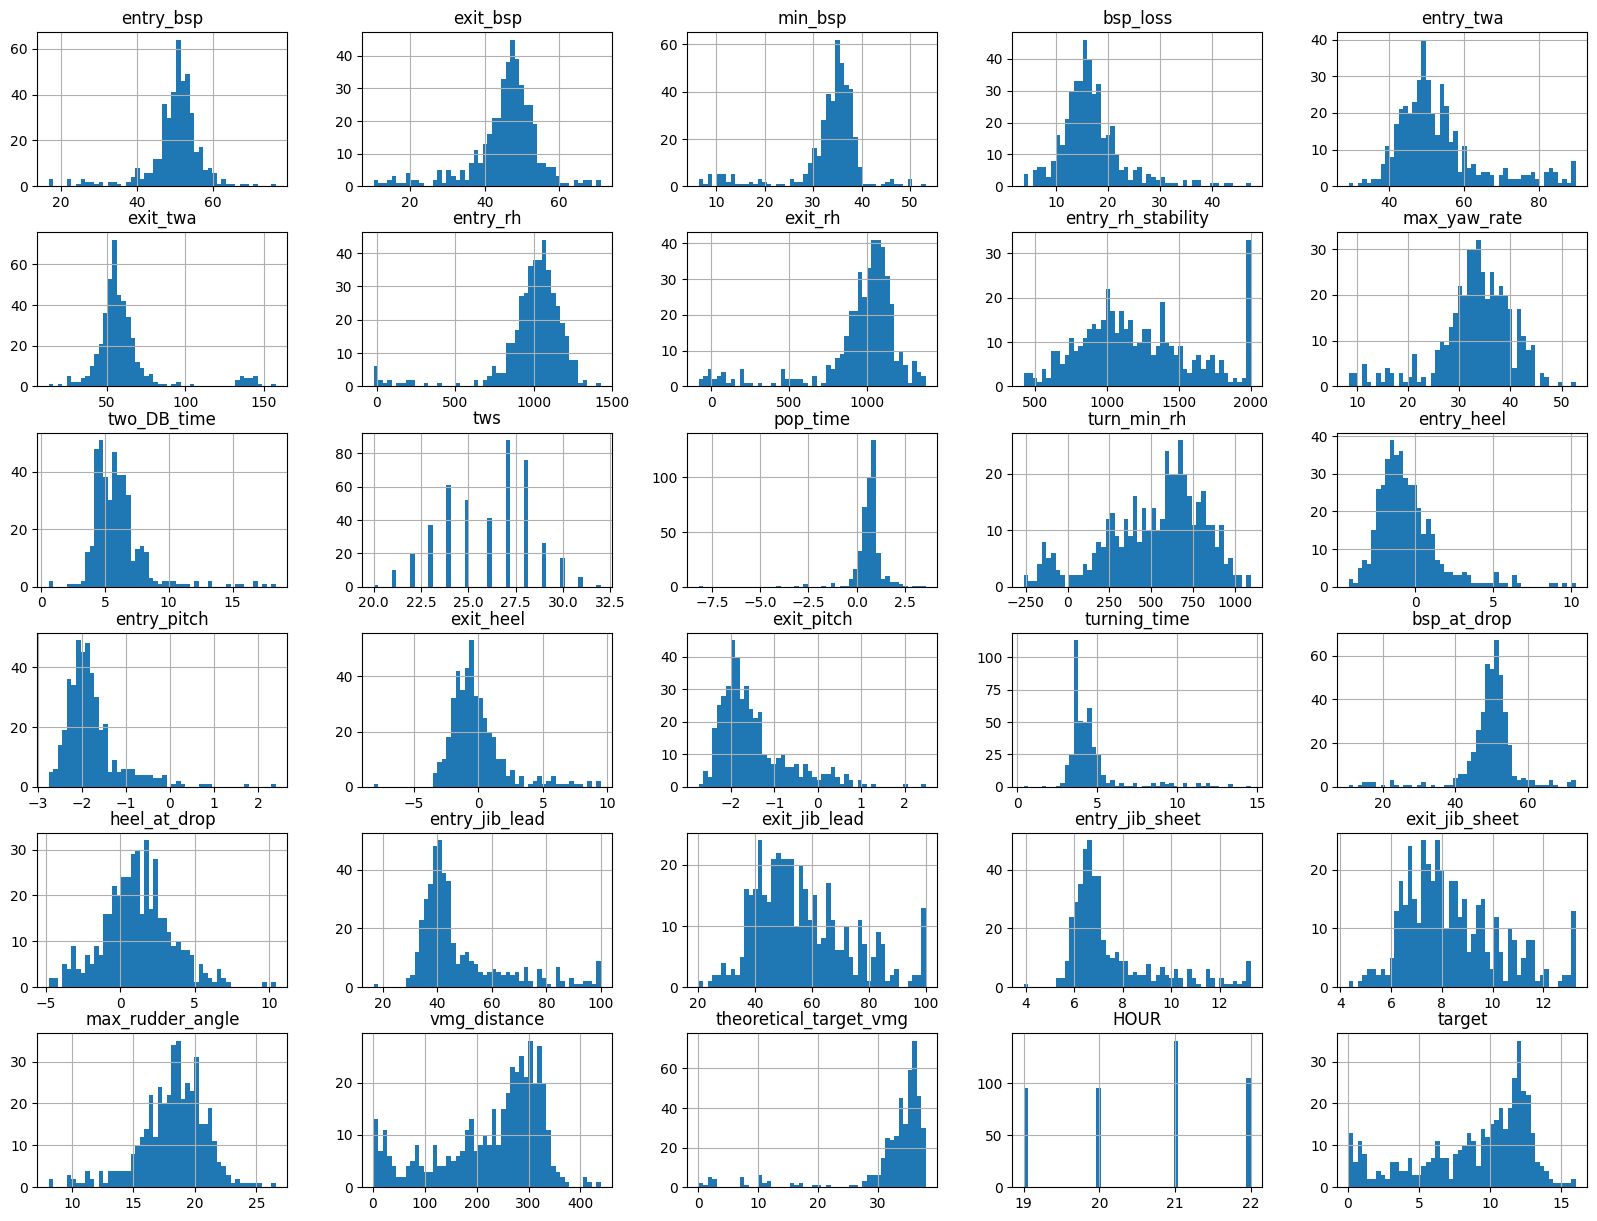



NOTE: 
    Most features have long tails - non-normal



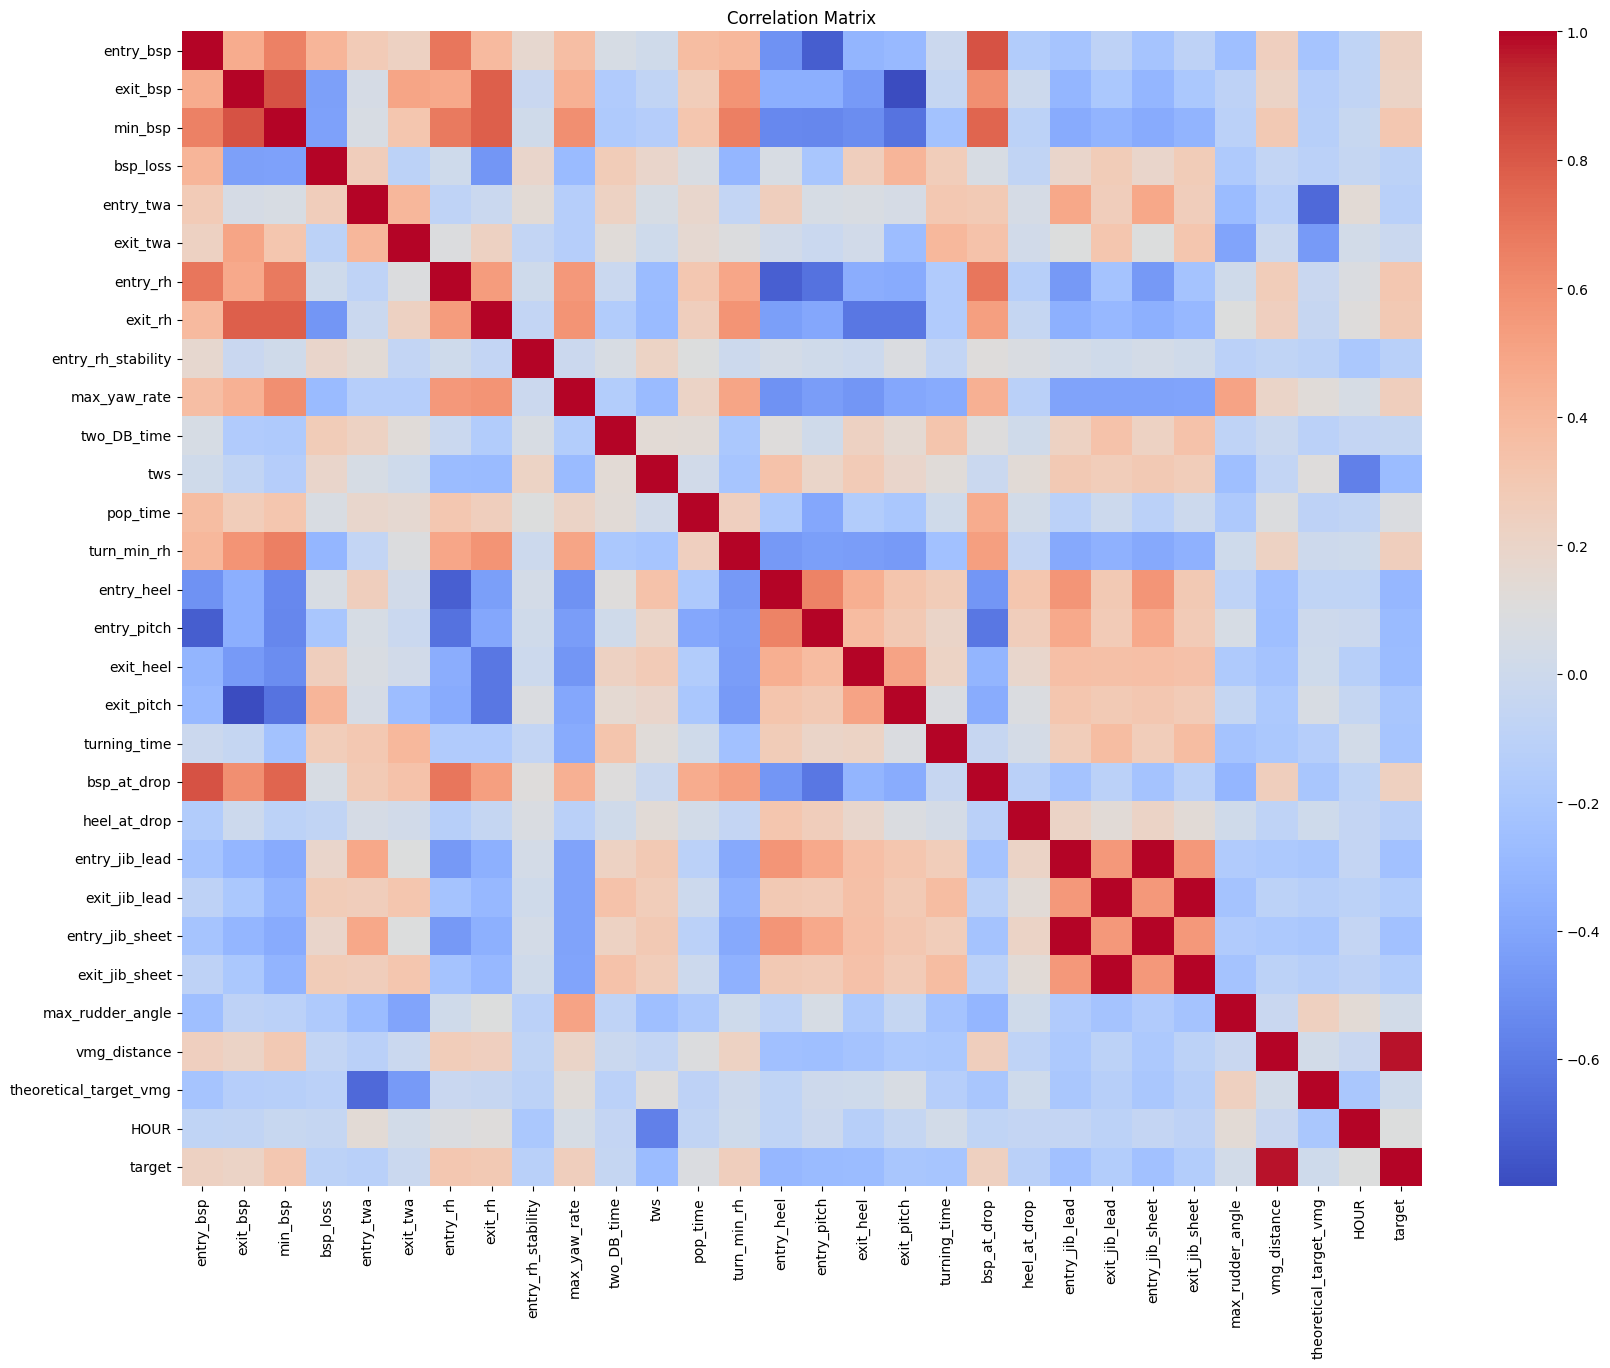



NOTE: 
    There are some strong clusters of correlations, suggesting removal.
    exit boatspeed and min boatspeed are highly correlated, also the boatspeed at drop is 
    highly correlated with the entry boatspeed. At least one of these four variables could
    be removed, suggest removal of min boatspeed as loss = entry - min, and loss is a 
    relative measure. Also suggest removal of bsp_at_drop in place of entry_bsp.


    Entry_jib_lead/entry_jib_sheet and exit_jib_lead/exit_jib_sheet are highly correlated. 
    As the data quality of the jib_sheet variables are poor, suggest removal of these 
    variables in place of their lead analogues



NOTE: 
  Remove vmg_distance from feature list (as target defined as vmg_distance/tws)
  remove empty, unneeded, co-correlated and leaky features



Check the extent of missing values:
 BOAT                   0
WING_CONFIG_unk        0
entry_bsp              0
exit_bsp               0
bsp_loss               0
entry_twa              0
ex

<Figure size 2000x1500 with 0 Axes>

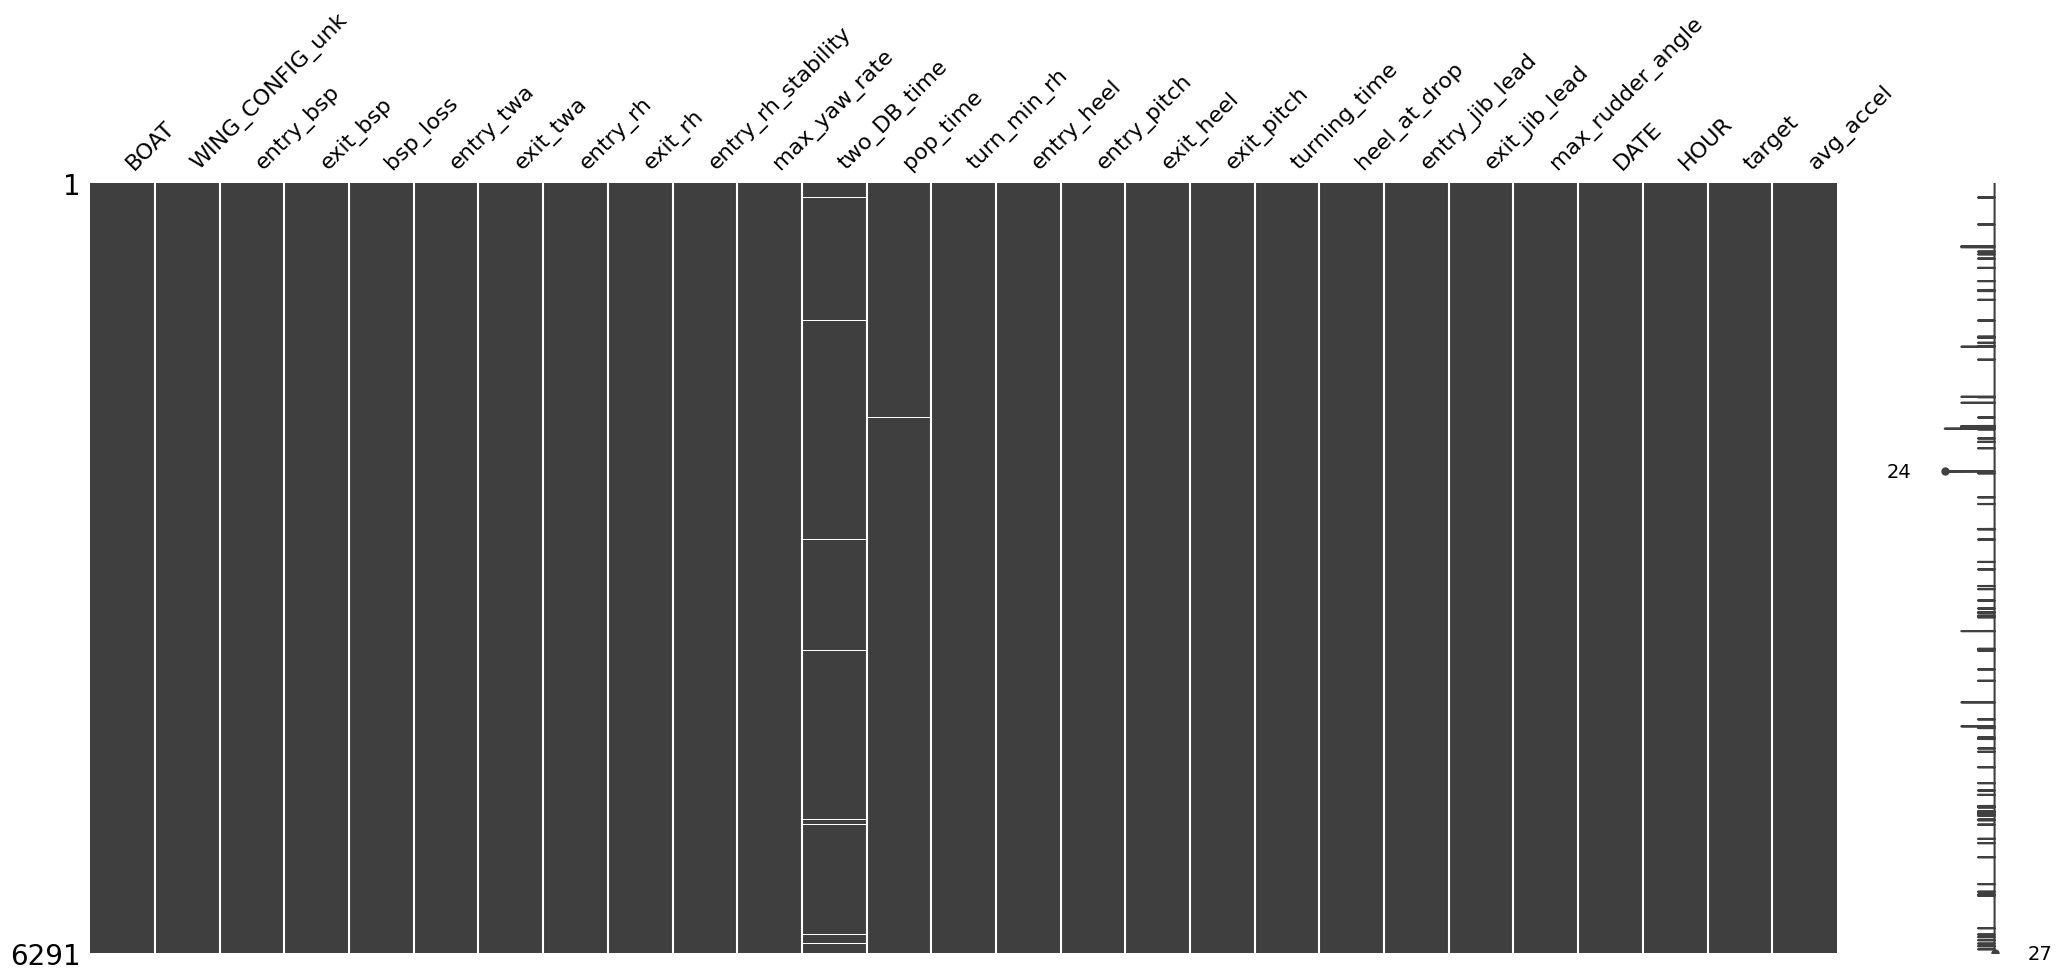



Medians before imputation:
 entry_rh              1022.05
entry_rh_stability     961.25
two_DB_time              5.40
pop_time                 1.00
turn_min_rh            442.95
dtype: float64


Medians after imputation:
 entry_rh              1022.05
entry_rh_stability     961.25
two_DB_time              5.40
pop_time                 1.00
turn_min_rh            442.95
dtype: float64


NOTE: 
  Basic outlier detection in place, calibrated using the sample subset for all 
  tacks on 16-06-23 ---> z-scores > 7 std devs are considered outliers. This method is 
  slightly flawed though as strictly the distributions will be independent to each unique 
  date as the conditions will change with location, time of year etc. Identifying outliers 
  based on the full distribution may result in removing inliers when the conditions are 
  extreme.


Outliers in WING_CONFIG_unk:
Series([], Name: WING_CONFIG_unk, dtype: float64)

Outliers in entry_bsp:
Series([], Name: entry_bsp, dtype: float64)

O

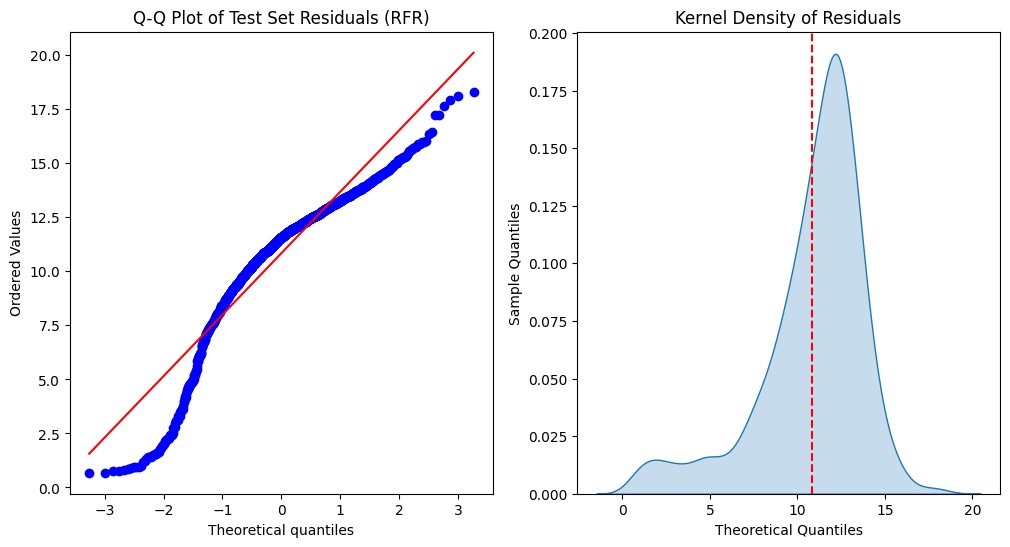

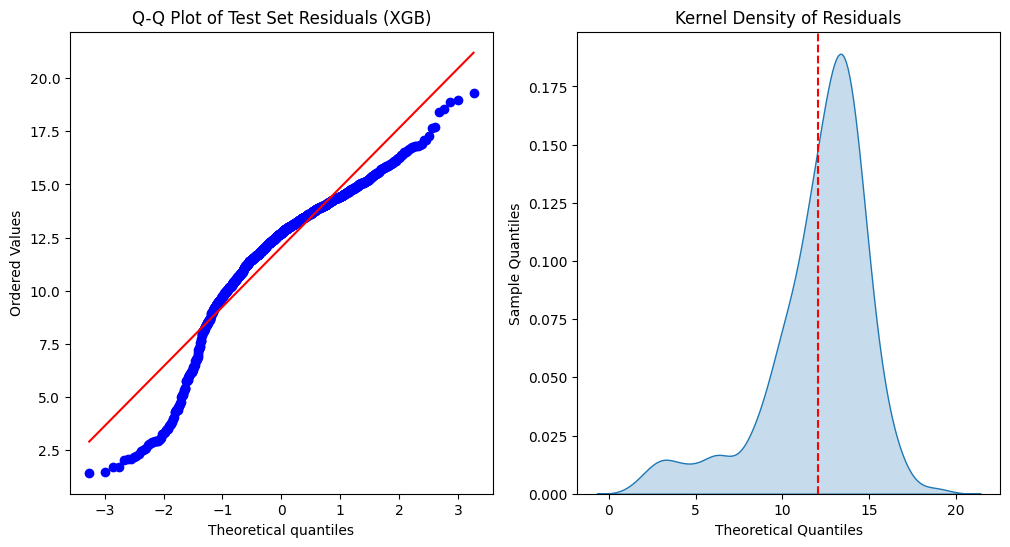



NOTE: 
  We can see that the distribution of residuals is actually not too bad.
  The q-q-plot is heavy-tailed and the residual distribution is left-skewed.



EXPERIMENTS:
 --- 1st attempt ---
 Initial results show that the model is massively overfitting for both models
 This is likely due to the dataset having multiple distributions due to
 different conditions, time of year, boat setup etc.
 Next step would be to apply some "potting" to the data.
 Train MAD ~ 0.04, Test MAD = 64

 --- 2nd attempt ---
 pot the data by configuration, doesn't seem to make a difference.
 For config = 11.0, test MAD = 64
 For config = 9.0, train MAD = 0.1/2e-4, test MAD = 39

 --- 3rd attempt ---
 try a single date - 16/06/23
 train MAD = 0.12/3e-4, test MAD = 44

 --- 4th attempt ---
 revert back to full dataset (no potting)
 further feature engineering ---> transformed target to remove tws relationship
 removed theoretical_vmg as may be causing target leakage (hence heavy overfitting)
 train MAD = 0.

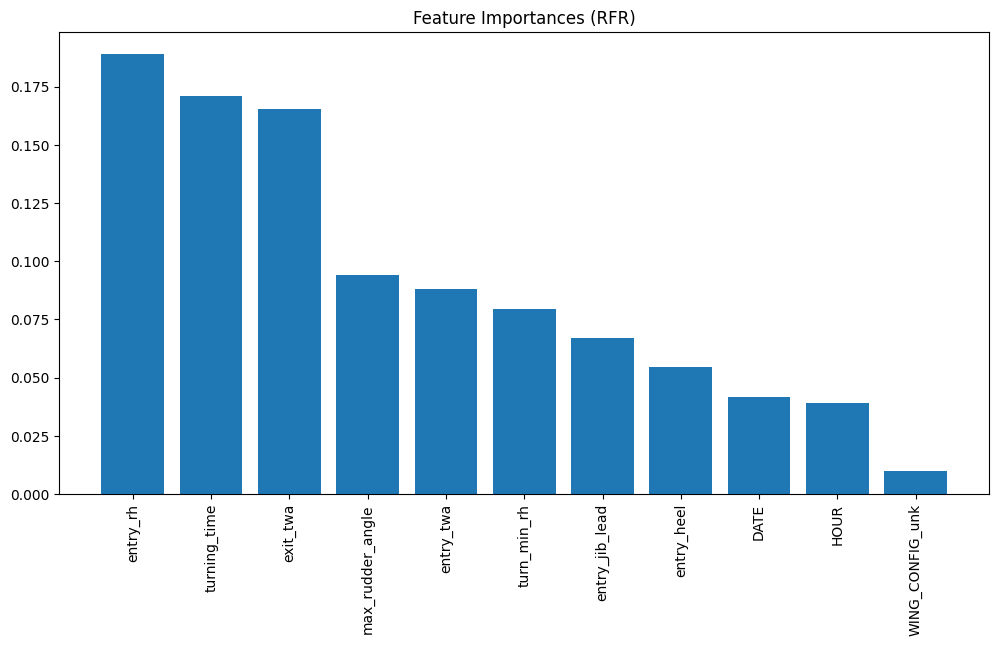

[0.16643296 0.15984914 0.13142811 0.100487   0.06921929 0.06592958
 0.06530814 0.06411946 0.06351079 0.06226921 0.05144629]


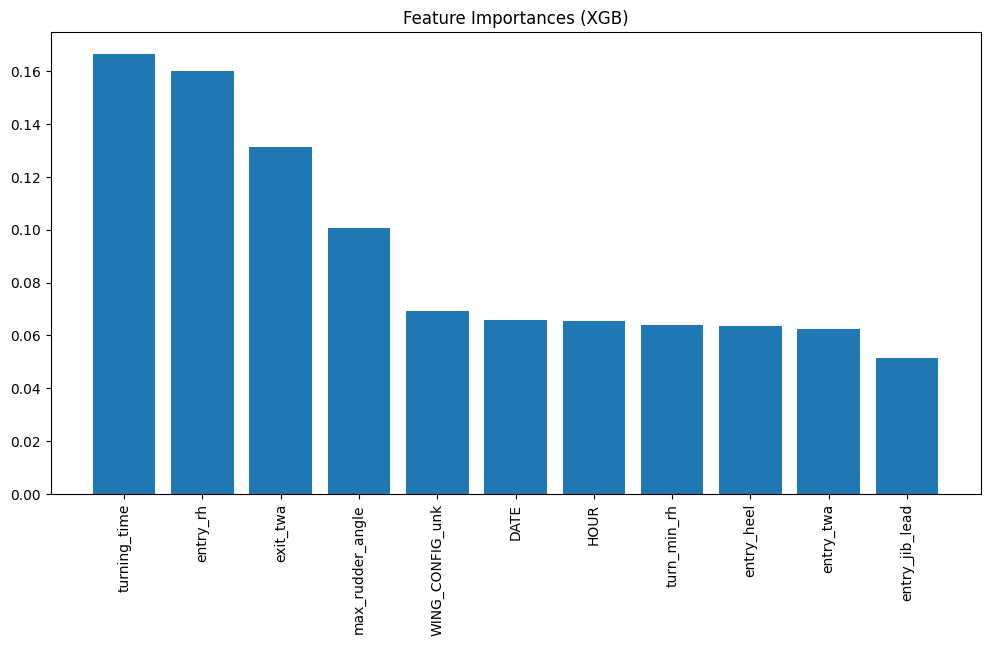



 FINAL REMARKS:
Two models were chosen - 1) Random Forest Regressor for the benefits of decision 
trees and the ensemble effect of the forest.

2) XGBoost has the advantages of RFR but also boosts trees depending on their strength.
The following model has been chosen:
  XGBoost
  Hyperparameters tuned using BayesianSearchCV
  Reduced feature list (using importance)
  Target = vmg_distance/tws

The pre-processing and cleaning steps were:
  Removal of empty or uninformative features
  Removal of features that result in target leakage
  Removal of highly co-correlated features
  Imputation of missing values with medians
  Standardisation of numerical variables (median centered)
  Encoding of categorical variables (OHE)
  Outlier removal using the modified Z score (median)

The model results are:
  XGBoost:
  -------------------------
  Train MAE: 0.31
  Test MAE: 12.05

  Train MAD: 0.23
  Test MAD: 1.42

  Train SE: 0.01
  Test SE: 0.08

The test results are not as strong as the traini

In [59]:
""" SailGP tack analysis project.
    -----------------------------
    Notebook which imports the dataset, performs some EDA, generates some features,
    builds some candidate models, evaluates model accuracy etc
    and interprets the model results """

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb
import warnings
import sys
import os
os.system('pip install scikit-optimize') #uncomment for first instance
from skopt import BayesSearchCV
from scipy.stats import zscore, probplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

mrow = 100
t_tack = 7.5 # tack time to min bsp in seconds i.e. time between entry bsp and min bsp
config = 9.0 # wing config for potting (must be a float)
feat_list = 'XGB' # 'RFR' / 'XGB' / 'all'
eda_flag = True
hparam_flag = False

warnings.simplefilter("ignore")
pd.options.display.min_rows = 0
pd.options.display.max_rows = mrow
pd.options.display.max_columns = mrow

# 2. Load the Dataset
df = pd.read_csv('tack_analysis.csv')

# 3. Exploratory Data Analysis (EDA)

# 3.1 Basic Information
print('\n\nINFO:\n')
print(df.info())
print('\n\nDESCRIBE:\n')
print(df.describe())

df['DATE'] = pd.to_datetime(df['DATETIME'], format='mixed').dt.date
df['HOUR'] = pd.to_datetime(df['DATETIME'], format='mixed').dt.hour
df['target'] = df['vmg_distance']/df['tws']

print("""\n\nNOTE:
  Looks like DATETIME might be a universal time and not local time,
   so splitting out the hours may be of little use\n""")

# print category numbers for analysis - 10 teams, type not useful, most tacks on 16-06-24
for cat in ('BOAT','type','DATE'):
  print('\n\nNumber of category',cat,':\n',df[cat].value_counts())

sample_date = pd.to_datetime('2023-06-16').date()

if eda_flag:
  # subsample data to a single date
  df_samp = df[df['DATE']==sample_date]

  # check that all teams were active on this date
  print('\n\nCheck if all teams present:\n',df_samp['BOAT'].value_counts(),'\n')

  # 3.2 Target Variable Distribution - Violin plot
  fig = plt.figure(figsize=(13.,10.))
  sns.violinplot(x='BOAT', y='target',data=df_samp, cut=0)
  plt.title('target distribution by team for 16-06-23')
  plt.show()
  print("""\n\nNOTE:
    Distributions are non-normal - need to account for outliers\n""")

  # 3.3 Target-feature relationships - scatter plots of all numerical features vs target
  def target_feat(df, target):
      numeric_columns = df.select_dtypes(include=['float64', 'int32']).columns
      for column in numeric_columns:
          if column != target:
              fig = px.scatter(df, x=column, y=target, title=f'{target} vs {column}')
              fig.show()
  target_feat(df_samp, 'target')
  print("""\n\nNOTE:
    Mixture of correlations and no relationship to target, some features
    are discrete e.g. tws\n""")

  # 3.4 Feature Distributions - histograms of all numerical features
  df_samp_num = df_samp.drop(columns=(['Unnamed: 0','BOAT','type',
    'WING_CONFIG_unk','DATETIME','DATE','t_invert']))
  df_samp_num.hist(bins=50, figsize=(20, 15))
  plt.show()
  print("""\n\nNOTE:
    Most features have long tails - non-normal\n""")

  # 3.5 Correlation Matrix
  fig = plt.figure(figsize=(20.,15.))
  corr_matrix = df_samp_num.corr()
  sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()
  print("""\n\nNOTE:
    There are some strong clusters of correlations, suggesting removal.
    exit boatspeed and min boatspeed are highly correlated, also the boatspeed at drop is
    highly correlated with the entry boatspeed. At least one of these four variables could
    be removed, suggest removal of min boatspeed as loss = entry - min, and loss is a
    relative measure. Also suggest removal of bsp_at_drop in place of entry_bsp.\n

    Entry_jib_lead/entry_jib_sheet and exit_jib_lead/exit_jib_sheet are highly correlated.
    As the data quality of the jib_sheet variables are poor, suggest removal of these
    variables in place of their lead analogues\n""")

# 4.1 Feature Engineering
# feature ideas:
# 1) deceleration = (bsp_loss)/(7.5/3600)
#   if turning_time = time between entry and exit then use
#   half of this instead for the time
# 2) acceleration = (exit_bsp-min_bsp)/(7.5/3600)
# 3) avg_accel = (accel+decel)/2

decel = df['bsp_loss']/(t_tack*3600)
accel = (df['exit_bsp'] - df['min_bsp'])/(t_tack*3600)
df['avg_accel'] = (decel + accel)/2

# NOT USED ----------------------------
# pot by config
#df = df[df['WING_CONFIG_unk']==config]

# pot by date
#df = df[df['DATE']==sample_date]
# -------------------------------------

print("""\n\nNOTE:
  Remove vmg_distance from feature list (as target defined as vmg_distance/tws)
  remove empty, unneeded, co-correlated and leaky features\n""")

df_clean = df.drop(columns=(['Unnamed: 0','type','DATETIME','t_invert','vmg_distance',
            'bsp_at_drop','min_bsp','entry_jib_sheet','exit_jib_sheet','tws',
                             'theoretical_target_vmg']))

# 4.2 Handling Missing Values
# Fill missing values or drop missing data

missing_values = df_clean.isnull()
print('\n\nCheck the extent of missing values:\n',missing_values.sum())
cols_miss = df_clean.columns[missing_values.sum() > 0]

# Visualise missing values
fig = plt.figure(figsize=(20, 15))
msno.matrix(df_clean)
plt.show()

# Impute missing values with their median values as all distributions with missing
# values are non-normal
meds = df_clean[cols_miss].median()
print('\n\nMedians before imputation:\n',meds)

df_clean[cols_miss] = df_clean[cols_miss].fillna(meds)
meds = df_clean[cols_miss].median()
print('\n\nMedians after imputation:\n',meds)

# 4.3 Outlier detection
print("""\n\nNOTE:
  Basic outlier detection in place, calibrated using the sample subset for all
  tacks on 16-06-23 ---> z-scores > 7 std devs are considered outliers. This method is
  slightly flawed though as strictly the distributions will be independent to each unique
  date as the conditions will change with location, time of year etc. Identifying outliers
  based on the full distribution may result in removing inliers when the conditions are
  extreme.\n""")

numeric_columns = df_clean.select_dtypes(include=['float64', 'int32']).columns

# Calculate Z-scores for each numeric column
z_scores = df_clean[numeric_columns].apply(zscore)

# Identify outliers which are more than 7 std devs from the mean
outliers = (np.abs(z_scores) >= 7)

# Check the outliers for each column
for column in numeric_columns:
    outlier_rows = df_clean[outliers[column]]
    print(f'\nOutliers in {column}:')
    print(outlier_rows[column])

# Remove outliers
df_clean = df_clean[(np.abs(z_scores) < 7).all(axis=1)]

# 4.4 Encoding Categorical Variables
# Encode categories and dates (HOUR does not need encoding as it is ordinal)
df_clean['WING_CONFIG_unk'] = df_clean['WING_CONFIG_unk'].astype('object')
cat_feats = df_clean.select_dtypes(include=['object']).columns
for col in cat_feats:
    col_cat = df_clean[col].astype('category').cat
    df_clean[col] = col_cat.codes
    print('\n\n'+col+' encodings = ',dict(enumerate(col_cat.categories)))


# 5. Model Building

# 5.0 Train-test split
# Reduced feature lists according to feature importance results on all features
if feat_list == 'RFR':
  df_clean = df_clean[['entry_rh', 'turning_time', 'exit_twa', 'max_rudder_angle',
                       'entry_twa', 'turn_min_rh', 'entry_jib_lead', 'target']]
elif feat_list == 'XGB':
  df_clean = df_clean[['turning_time', 'entry_rh', 'exit_twa', 'max_rudder_angle',
                       'entry_twa', 'entry_heel', 'turn_min_rh', 'entry_jib_lead',
                       'WING_CONFIG_unk', 'HOUR', 'DATE', 'target']]
elif feat_list == 'all':
  df_clean = df_clean

X = df_clean.drop('target', axis=1)
y = df_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.1 Feature Scaling
print("""\n\nNOTE:
  I prefer RobustScalar as it standardises using the median, whereas
  other scalars use the mean or min/max which are susceptible to outliers
  important to standardise after splitting train and test sets,
  else the test set distribution will leak into the training data\n""")

scaler = RobustScaler()
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_feats = Xy_train.select_dtypes(include=['int32', 'float64']).columns
Xy_train[Xy_feats] = scaler.fit_transform(Xy_train[Xy_feats])
X_train = Xy_train.drop('target', axis=1)
y_train = Xy_train['target']

# 5.2.1 Hyperparameter tuning
if hparam_flag:

  # Perform Bayesian search (RFR)
  # -----------------------------
  # Define the hyperparameter space
  param_grid_rfr = {
    'n_estimators': (10, 100),
    'max_depth': (1, 25),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (1, 5)
  }

  bayes_search = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid_rfr, n_iter=32, cv=3, random_state=42, n_jobs=-1)

  bayes_search.fit(X_train, y_train)

  # Best parameters
  print("\n\nBest RFR parameters found by Bayesian search:", bayes_search.best_params_,'\n')

  # Perform Bayesian search (XGB)
  # -----------------------------
  # Define the hyperparameter space
  param_grid_xgb = {
    'n_estimators': (50, 150),
    'max_depth': (3, 10),
    'learning_rate': (0.05, 0.3, 'log-uniform'),
    'subsample': (0.75, 1.0),
    'colsample_bytree': (0.75, 1.0),
    'min_child_weight': (1, 5)
  }

  # Initialize XGBoost Regressor
  xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

  # Perform Bayesian search
  bayes_search_xgb = BayesSearchCV(estimator=xgb_regressor, search_spaces=param_grid_xgb,
    n_iter=32, cv=3, random_state=42, n_jobs=-1)
  bayes_search_xgb.fit(X_train, y_train)

  # Best parameters
  print("\n\nBest parameters found by Bayesian search:", bayes_search_xgb.best_params_,'\n')


# 5.2.2 Define the Models
# parameters tuned using BayesianSearchCV
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=25, min_samples_leaf=1,
                                  min_samples_split=2, random_state=42)
model_xgb = xgb.XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.09,
                             subsample=1.0, colsample_bytree=0.78, min_child_weight=5,
                             random_state=42)

# 5.3 Train the Models
model_rfr.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)


# 6. Model Evaluation

# 6.1 Train and test set predictions
preds_train_rfr = model_rfr.predict(X_train)
preds_train_xgb = model_xgb.predict(X_train)

preds_test_rfr = model_rfr.predict(X_test)
preds_test_xgb = model_xgb.predict(X_test)

# 6.2 Performance metrics
# MAE, MAD and 4*SE
# also do a q-q-plot of the residuals to check if they are normal
# then 4*SE will account for 95% of the residuals

# Calculate residuals
train_res_rfr = y_train - preds_train_rfr
train_res_xgb = y_train - preds_train_xgb

test_res_rfr = y_test - preds_test_rfr
test_res_xgb = y_test - preds_test_xgb

# Calculate MAE
train_mae_rfr = np.mean(np.abs(train_res_rfr))
train_mae_xgb = np.mean(np.abs(train_res_xgb))

test_mae_rfr = np.mean(np.abs(test_res_rfr))
test_mae_xgb = np.mean(np.abs(test_res_xgb))

# Calculate MAD
train_mad_rfr = np.median(np.abs(train_res_rfr - np.median(train_res_rfr)))
train_mad_xgb = np.median(np.abs(train_res_xgb - np.median(train_res_xgb)))

test_mad_rfr = np.median(np.abs(test_res_rfr - np.median(test_res_rfr)))
test_mad_xgb = np.median(np.abs(test_res_xgb - np.median(test_res_xgb)))

# Calculate SE
train_se_rfr = np.std(train_res_rfr) / np.sqrt(len(train_res_rfr))
train_se_xgb = np.std(train_res_xgb) / np.sqrt(len(train_res_xgb))

test_se_rfr = np.std(test_res_rfr) / np.sqrt(len(test_res_rfr))
test_se_xgb = np.std(test_res_xgb) / np.sqrt(len(test_res_xgb))

# Display Metrics
print("\n\nRandom Forest Regression:")
print("-------------------------")
print(f"Train MAE: {train_mae_rfr}")
print(f"Test MAE: {test_mae_rfr}")

print(f"\nTrain MAD: {train_mad_rfr}")
print(f"Test MAD: {test_mad_rfr}")

print(f"\nTrain SE: {train_se_rfr}")
print(f"Test SE: {test_se_rfr}")


print("\n\nXGBoost:")
print("-------------------------")
print(f"Train MAE: {train_mae_xgb}")
print(f"Test MAE: {test_mae_xgb}")

print(f"\nTrain MAD: {train_mad_xgb}")
print(f"Test MAD: {test_mad_xgb}")

print(f"\nTrain SE: {train_se_xgb}")
print(f"Test SE: {test_se_xgb}\n")

# Q-Q plot for residuals against normal distribution (RFR)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
probplot(test_res_rfr, dist="norm", plot=axes[0])
sns.kdeplot(test_res_rfr, ax=axes[1], shade=True, label='Residuals')
axes[1].axvline(np.mean(test_res_rfr), color='r', linestyle='--')
axes[1].set_title('Kernel Density of Residuals')
axes[0].set_title('Q-Q Plot of Test Set Residuals (RFR)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Q-Q plot for residuals against normal distribution (XGB)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
probplot(test_res_xgb, dist="norm", plot=axes[0])
sns.kdeplot(test_res_xgb, ax=axes[1], shade=True, label='Residuals')
axes[1].axvline(np.mean(test_res_xgb), color='r', linestyle='--')
axes[1].set_title('Kernel Density of Residuals')
axes[0].set_title('Q-Q Plot of Test Set Residuals (XGB)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

print("""\n\nNOTE:
  We can see that the distribution of residuals is actually not too bad.
  The q-q-plot is heavy-tailed and the residual distribution is left-skewed.\n""")

print("""\n\nEXPERIMENTS:
 --- 1st attempt ---
 Initial results show that the model is massively overfitting for both models
 This is likely due to the dataset having multiple distributions due to
 different conditions, time of year, boat setup etc.
 Next step would be to apply some "potting" to the data.
 Train MAD ~ 0.04, Test MAD = 64

 --- 2nd attempt ---
 pot the data by configuration, doesn't seem to make a difference.
 For config = 11.0, test MAD = 64
 For config = 9.0, train MAD = 0.1/2e-4, test MAD = 39

 --- 3rd attempt ---
 try a single date - 16/06/23
 train MAD = 0.12/3e-4, test MAD = 44

 --- 4th attempt ---
 revert back to full dataset (no potting)
 further feature engineering ---> transformed target to remove tws relationship
 removed theoretical_vmg as may be causing target leakage (hence heavy overfitting)
 train MAD = 0.11/0.20, test MAD = 1.40/1.45 ---> an acceptable model

 --- 5th attempt ---
 hyperparameter tuning - bayesian search CV, more sophisticated than random CV and
  cheaper than grid search
 "Best RFR parameters found by Bayesian search: OrderedDict([('max_depth', 25),
 ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])"
 "Best parameters found by Bayesian search: OrderedDict([('colsample_bytree', 0.78),
 ('learning_rate', 0.09), ('max_depth', 5), ('min_child_weight', 5),
 ('n_estimators', 150), ('subsample', 1.0)])"
 train MAD = 0.11/0.20, test MAD = 1.40/1.45
 unfortunately, no improvement ---> could extend parameter grid

 --- 6th attempt ---
 reduced feature list ---> remove features with < 3% score for feature importance
 RFR = entry_rh, turning_time, exit_twa, max_rudder_angle, entry_twa, turn_min_rh,
  entry_jib_lead
 XGB = turning_time, entry_rh, exit_twa, max_rudder_angle, entry_twa, entry_heel
  turn_min_rh, entry_jib_lead, WING_CONFIG_unk, HOUR, DATE
 train MAD = 0.13/0.23, test MAD = 1.41/1.42
 very slight improvement for XGB model, could redo hparam search to squeeze a little more\n""")


# 7. Model Interpretation
# 7.1 Feature Importance
# RFR
importances = model_rfr.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (RFR)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

# XGB
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (XGB)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


# 8. Conclusion and Next Steps
# Summarize findings, potential improvements, and next steps for further analysis

print("""\n\n FINAL REMARKS:
Two models were chosen - 1) Random Forest Regressor for the benefits of decision
trees and the ensemble effect of the forest.\n
2) XGBoost has the advantages of RFR but also boosts trees depending on their strength.
The following model has been chosen:
  XGBoost
  Hyperparameters tuned using BayesianSearchCV
  Reduced feature list (using importance)
  Target = vmg_distance/tws

The pre-processing and cleaning steps were:
  Removal of empty or uninformative features
  Removal of features that result in target leakage
  Removal of highly co-correlated features
  Imputation of missing values with medians
  Standardisation of numerical variables (median centered)
  Encoding of categorical variables (OHE)
  Outlier removal using the modified Z score (median)

The model results are:
  XGBoost:
  -------------------------
  Train MAE: 0.31
  Test MAE: 12.05

  Train MAD: 0.23
  Test MAD: 1.42

  Train SE: 0.01
  Test SE: 0.08

The test results are not as strong as the training results which may be expected to a small
degree. The MAE is much larger than the MAD suggesting there may still be outliers present.
The SE is small and ~95% of the residuals have a spread of 4*SE = 0.32 which is relatively
small, suggesting that the residual distribution is tight around the centre, this can also be
seen in the KDE plot of residuals. The q-q-plot also shows that the residuals have a
heavy tailed normal distribution.


Improvements/next steps:
  The hyperparameter search could be redone using the reduced feature list and also with an
    extended parameter grid.
  The outlier removal threshold (currently 7 sigma - quite high) could be tuned to see the
    effect on the results. The MAE suggests there may still be some outliers affecting the accuracy.
  Could try a third model e.g. NN.
""")






